# ADMM for Edge LASSO 

The edge- LASSO (Least Absolute Shrinkage and Selection Operator) problem corresponds to $L_1$ regularization on graphs. The solution in this case is a sparse and smooth signal on the graph. It is formulated in the following way: 
$$
	\mathbf{x}^\star = \arg\min_{\mathbf{x}\in\mathbb{R}^n} \frac{q}{2}||\mathbf{x} - \mathbf{y}||_2^2 + || \mathsf{B}\mathbf{x} ||_1,
$$
where $\mathsf{B}\in\mathbb{R}^{m\times n}$ is the edge-incidence matrix that takes the following form: 
$$
    \mathsf{B}_{i,k} = \begin{cases}
        - w(i,j) & i< j \text{ and } e_k=(i,j)\in\mathcal{E} \\
        w(i,j) & i> j  \text{ and } e_k=(i,j)\in\mathcal{E} \\ 
        0 & \text{otherwise}
    \end{cases}.
$$
In other words, $\mathsf{B}\mathbf{x}$ computes the gradients of the signal $\mathbf{x}$ over the edges. Then, by taking the $L_1$ norm of this vector, one has the total absolute gradient of $\mathbf{x}$. As aforementioned, minimization over this regularization cost yields a sparse and smooth signal. 

In [1]:
using KirchoffForests
using Graphs
using StatsBase
using Distributions
using SparseArrays
using LinearAlgebra
using PoissonRandom
using PyPlot

In [2]:
using TestImages, ImageQualityIndexes,Images

In [3]:
imname = "house"
image = imresize(testimage(imname), 128, 128)
image = Float64.(Gray.(image))
nx = size(image,1)
ny = size(image,2)
rs = (v) -> reshape(v,nx,ny)
G = Graphs.grid([nx,ny])
image = image[:]
nrep = 20

σ = 0.2
mu = 5.0

5.0

In [4]:
im_noisy = image .+ randn(length(image))*σ;

## Denoising Gaussian noise via ADMM . 
In this example, we consider an image denoising application where the noise is assumed to be additive Gaussian noise: 
$$
    \mathbf{y} = \mathbf{x} + \mathbf{\epsilon}, \quad \forall i \in \mathcal{V}, \epsilon_i \sim\mathcal{N}(\mathbf{0},\mathsf{I}) 
$$
Then, for the problem above, one can approximate the solution by using the method of ADMM. This method iteratively solves the problem at hand by running the iterative steps: 
$$
\begin{split}
	\mathbf{x}_{k+1} &= \arg\min_{\mathbf{x} \in\mathbb{R}^n}\left(\frac{q}{2}||\mathbf{x}-\mathbf{y}||_2^2 + \frac{\rho}{2}||\mathsf{B}\mathbf{x} -\mathbf{z}_{k}+\mathbf{u}_{k}||_2^2\right) \\
	\mathbf{z}_{k+1} &= \arg\min_{\mathbf{z} \in\mathbb{R}^m}\left(||\mathbf{z}||_1 + \frac{\rho}{2}||\mathsf{B}\mathbf{x}_{k+1} -\mathbf{z}+\mathbf{u}_{k}||_2^2 \right) \\
	\mathbf{u}_{k+1} &= \mathbf{u}_k + (\mathsf{B}\mathbf{x}^{k+1} - \mathbf{z}^{k+1}). \\
\end{split}
$$
The parameters $\mathbf{x}_k$, $\mathbf{y}_k$ and $\mathbf{u}_k$ are arbitrarily initialized and are updated at every step, and $\rho$ is a user-defined parameter. Here, the computationally heavy part is the first step in which one needs to compute this inverse: 
$$
    \mathbf{x}_{k+1} = (q\mathsf{I} + \rho\mathsf{L})^{-1}(q\mathbf{y} + \rho\mathsf{B}^{\top}\mathbf{z}_k - \rho\mathsf{B}^\top\mathbf{u}_k).
$$
Notice that one can see this inverse as the regularized inverse of $\mathsf{L}$, thus it can be approximated via forest-based estimators. Moreover, the updated part through iterations is not the inverse but the vector that the inverted matrix is multiplied with. This allows us to sample spanning forests once and use them for every iterations. This idea has not implemented yet, so the following function implements ADMM with the exact and forest based updates while forests are sampled at every iterations.  


In [5]:
@elapsed xadmm_exact,loss_func_exact= admm_edge_lasso(G,mu,im_noisy;maxiter=200,ρ=0.2,method="exact")

25.171844969

In [6]:
@elapsed xadmm_forest,loss_func_forest= admm_edge_lasso(G,mu,im_noisy;maxiter=200,ρ=0.2,method="xbar",Nfor=3)

4.580849309

In [7]:
xadmm_exact= rs(xadmm_exact)
xadmm_forest= rs(xadmm_forest);

Both qualitative and quantitative result shows that forest-based updates empirically converges the solution computed by the exact updates while taking much less time. Moreover, the sparse (almost piece-wise constant) structure of the solution is clearly visible on these image examples.

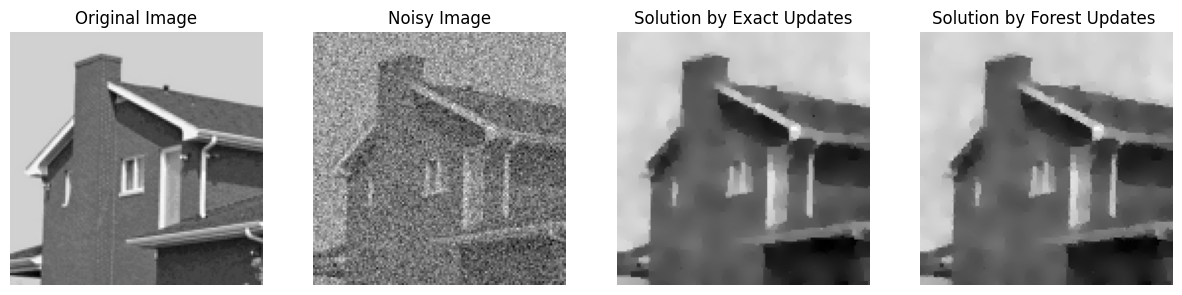

(-0.5, 127.5, 127.5, -0.5)

In [8]:
figure(figsize=[15,4])
subplot(1,4,1)
title("Original Image")
imshow(rs(image),cmap="gray")
axis("off")
subplot(1,4,2)
title("Noisy Image")
imshow(rs(im_noisy),cmap="gray")
axis("off")
subplot(1,4,3)
title("Solution by Exact Updates")
imshow(xadmm_exact,cmap="gray")
axis("off")
subplot(1,4,4)
title("Solution by Forest Updates ")
imshow(rs(xadmm_forest),cmap="gray")
axis("off")


In [9]:
y = rs(im_noisy)
noisy_psnr = (ImageQualityIndexes.assess_psnr(y, image))
xadmm_exact_psnr = (ImageQualityIndexes.assess_psnr(xadmm_exact, image))
xforest_psnr = (ImageQualityIndexes.assess_psnr(xadmm_forest, image))

display("y psnr: $noisy_psnr")
display("xadmm_exact psnr: $xadmm_exact_psnr")
display("xforest psnr : $xforest_psnr")

"y psnr: 13.972511184499886"

"xadmm_exact psnr: 23.860703046152313"

"xforest psnr : 23.816177942582524"

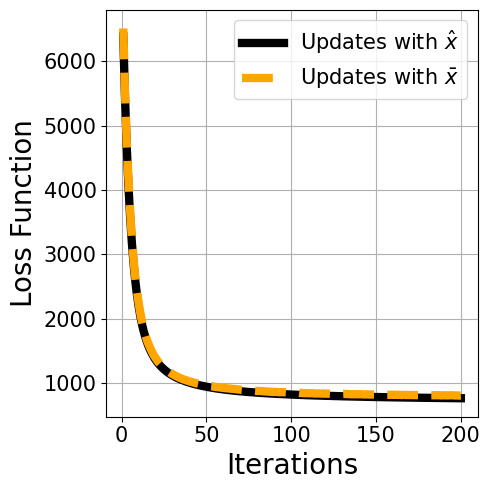

PyObject <matplotlib.legend.Legend object at 0x7f5b5004c460>

In [10]:
fig = figure(figsize=[5,5])
plot((1:length(loss_func_exact)), loss_func_exact, color="black",linewidth=6.0, label=string("Updates with ", latexstring("\$\\hat{x}\$")))
plot((1:length(loss_func_forest)), loss_func_forest, color="orange",linewidth=6.0,linestyle="--", label=string("Updates with ", latexstring("\$\\bar{x}\$")))
xlabel("Iterations",fontsize=20)
ylabel("Loss Function",fontsize=20)
xticks(fontsize=15)
yticks(fontsize=15)
PyPlot.grid(true)
tight_layout()
legend(fontsize=15)
